# To Replicate Test:
Create an empty (containing only "{}") json file at the path *.\atmo_chem\\NASAcomparison.json*. Run the command 

`jupyter nbconvert --to notebook --execute --inplace --allow-errors atmo_chem.ipynb`

in terminal 50 times (in a loop, for example). This will populate *atmo_chem\\NASAcomparison.json* with the results for each of the 50 stations. These data are visualized in *figures.ipynb*.

Make sure the data is located at *atmo_chem\\stations\\* and follows the naming convention: observed data files start with "obs_" and NASA model forecasts start with "model_forecast_".

In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

from scipy.stats import norm, skewnorm, gamma
%load_ext autoreload
%autoreload 2

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import GammaNLL, SkewNormalNLL

In [4]:
def pinball_loss(data, quant_preds, quantiles):
    assert(len(data) == len(quant_preds))
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
def nmb(data, pred):
    """Normalized mean bias"""
    assert(len(data) == len(pred))
    return np.mean(pred - data) / np.mean(data)

def nrmse(data, pred):
    """Normalized root mean square error"""
    assert(len(data) == len(pred))
    sorted_data = sorted(data)
    o05 = sorted_data[int(len(data) * 0.05)]
    o95 = sorted_data[int(len(data) * 0.95)]
    return np.sqrt(np.mean((data - pred)**2)) / (o95 - o05)

from scipy.stats import pearsonr
def correlation(data, pred):
    """Pearson correlation"""
    assert(len(data) == len(pred))
    return pearsonr(data, pred)[0]    

In [6]:
import json
with open(".\\atmo_chem\\NASAcomparison.json") as f:
    NASAcomparison = json.loads(f.read())
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

In [7]:
station_path = ".\\atmo_chem\\stations\\"
for fname in os.listdir(station_path):
    if fname.startswith("obs_") and fname[len("obs_"):-len(".csv")] not in NASAcomparison.keys():
        station_name = fname[len("obs_"):-len(".csv")]
        break
station_name

NameError: name 'station_name' is not defined

In [8]:
# TODO: REMOVE
station_name = "Station0004436"  # Seattle
# station_name = "JPN_Tokyo_13117520"

In [9]:
NASAcomparison[station_name] = dict()

obsfile = os.path.join(station_path, 'obs_%s.csv'.replace('%s',station_name))
obs = pd.read_csv(obsfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
t_min = obs.t.min()
obs.t -= t_min
obs_no2 = obs.loc[obs.obstype=='no2']
obs_o3 = obs.loc[obs.obstype=='o3']
obs_pm25 = obs.loc[obs.obstype=='pm25']
 
modfile = os.path.join(station_path, 'model_forecast_%s.csv'.replace('%s',station_name))
mod = pd.read_csv(modfile, parse_dates=['ISO8601','ISO8601_init'],date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601_init','ISO8601'])
mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]
mod.t -= t_min

In [10]:
obs

,ISO8601,localtime,location,original_station_name,lat,lon,obstype,conc_mod,conc_obs,conc_unit,t
0,2018-01-01 02:00:00,2017-12-31T18:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,pm25,21.2877,5.6,ugm-3,0.0
1,2018-01-01 02:00:00,2017-12-31T18:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,31.6068,9.0,ppbv,0.0
2,2018-01-01 02:00:00,2017-12-31T18:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,o3,3.7835,18.0,ppbv,0.0
3,2018-01-01 12:00:00,2018-01-01T04:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,pm25,13.8420,13.1,ugm-3,36000.0
4,2018-01-01 12:00:00,2018-01-01T04:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,14.9303,13.0,ppbv,36000.0
...,...,...,...,...,...,...,...,...,...,...,...
66003,2021-03-14 19:00:00,2021-03-14T11:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,13.2423,15.0,ppbv,100972800.0
66005,2021-03-14 19:00:00,2021-03-14T11:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,pm25,12.7254,12.0,ugm-3,100972800.0
66007,2021-03-14 20:00:00,2021-03-14T12:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,o3,29.9769,16.0,ppbv,100976400.0
66006,2021-03-14 20:00:00,2021-03-14T12:00:00Z,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,11.4524,14.0,ppbv,100976400.0


In [11]:
mod

,ISO8601_init,ISO8601,location,lat,lon,NO2,O3,PM25_RH35_GCC,t
0,2019-01-01,2019-01-01 12:30:00,Station0004436,47.5682,-122.3086,2.398163e-08,1.209264e-08,24.297377,31573800.0
1,2019-01-01,2019-01-01 13:30:00,Station0004436,47.5682,-122.3086,2.371968e-08,1.188892e-08,24.409668,31577400.0
2,2019-01-01,2019-01-01 14:30:00,Station0004436,47.5682,-122.3086,2.395251e-08,1.085573e-08,24.813950,31581000.0
3,2019-01-01,2019-01-01 15:30:00,Station0004436,47.5682,-122.3086,2.444726e-08,9.851647e-09,24.845991,31584600.0
4,2019-01-01,2019-01-01 16:30:00,Station0004436,47.5682,-122.3086,2.319579e-08,1.120498e-08,25.575287,31588200.0
...,...,...,...,...,...,...,...,...,...
43550,2019-12-31,2020-01-05 07:30:00,Station0004436,47.5682,-122.3086,7.443342e-09,2.898758e-08,6.063825,63437400.0
43551,2019-12-31,2020-01-05 08:30:00,Station0004436,47.5682,-122.3086,8.192761e-09,2.782390e-08,6.778789,63441000.0
43552,2019-12-31,2020-01-05 09:30:00,Station0004436,47.5682,-122.3086,8.658420e-09,2.680464e-08,7.293846,63444600.0
43553,2019-12-31,2020-01-05 10:30:00,Station0004436,47.5682,-122.3086,7.901721e-09,2.764864e-08,6.569568,63448200.0


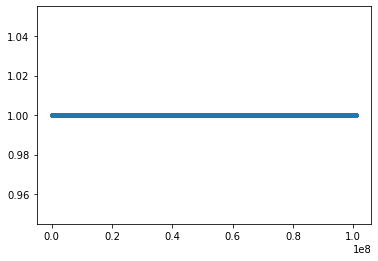

In [12]:
plt.figure()
plt.plot(obs.t, np.ones(len(obs.t)), ".")

In [13]:
diff = -(pd.to_datetime(mod.ISO8601_init) - pd.to_datetime(mod.ISO8601))
five_day_mod = mod[(diff > dt.timedelta(days=4)) & (diff < dt.timedelta(days=5))]
mods = dict()
for num_ahead in range(1, 6):
    mods[f"ahead{num_ahead}"] = mod[(diff > dt.timedelta(days=num_ahead - 0.5)) & (diff < dt.timedelta(days=num_ahead + 0.5))]

In [14]:
mods_no2 = [mods[x].NO2.values[:8707] for x in mods.keys()]
mods_no2 = np.array(mods_no2).T
mods_o3 = [mods[x].O3.values[:8707] for x in mods.keys()]
mods_o3 = np.array(mods_o3).T
mods_pm25 = [mods[x].PM25_RH35_GCC.values[:8707] for x in mods.keys()]
mods_pm25 = np.array(mods_pm25).T

In [15]:
mods_no2.shape,mods_o3.shape,mods_pm25.shape,

((8707, 5), (8707, 5), (8707, 5))

In [16]:
chemical = "NO2"
x = np.expand_dims(obs_no2.conc_obs.values, -1)
t = obs_no2.t.values
print("x", x.shape)
print("t", t.shape)

x (22331, 1)
t (22331,)


In [17]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [18]:
if x.min() <= 0:
    print("negative observed concentration: ", x[x<=0])
    x[x <= 0] = 1e-20

negative observed concentration:  [0. 0. 0. 0. 0.]


In [19]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (22331, 1)
t (22331,)


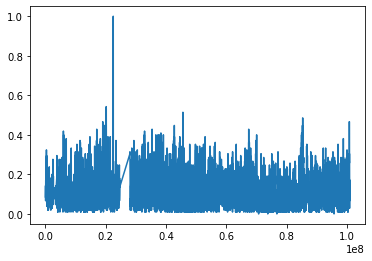

In [20]:
plt.figure()
plt.plot(t, x)

In [21]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [22]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (22331, 1)
xt (5314, 1)


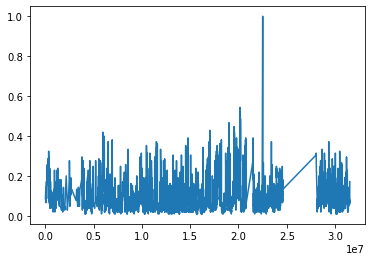

In [23]:
plt.figure()
plt.plot(tt, xt)

In [24]:
mod_quant_preds = 1e9 / rnge * (mods_no2[1:, :] + mods_no2[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60  # because interpolating 30 minutes
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [25]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [26]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [27]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5724421
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6220981
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.66369635
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.69914734
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   604800.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.0473769
Iteration  36
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.0546906
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.0616915
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.0689017
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,  

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.2592963
Iteration  72
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.263585
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.267503
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.2716144
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   6

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.3634725
Iteration  108
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.3653195
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.3673925
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.3689814
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4095231
Iteration  144
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4104552
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4111797
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4123553
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4297582
Iteration  180
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4303778
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4306079
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4310509
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.439856
Iteration  216
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4401106
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4408224
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4407434
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4458001
Iteration  252
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.445987
Iteration  253
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4461117
Iteration  254
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4462585
Iteration  255
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4502038
Iteration  288
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4503229
Iteration  289
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4508783
Iteration  290
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4508051
Iteration  291
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.453638
Iteration  324
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4537205
Iteration  325
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4538745
Iteration  326
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4543878
Iteration  327
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4567182
Iteration  360
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4566692
Iteration  361
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4565742
Iteration  362
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4566923
Iteration  363
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

In [363]:
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [365]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [366]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

<IPython.core.display.Javascript object>


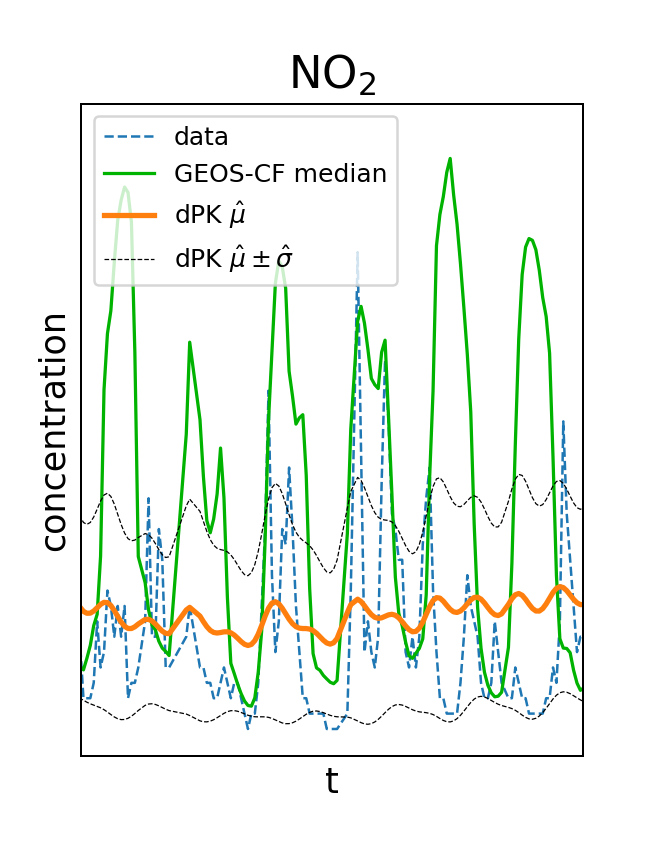

In [364]:
# for figure
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
#     plt.figure(dpi=150)
    plt.subplots(figsize=[3,4], dpi=150)
    plt.subplot(111)
#     marker=(2, 0, 0)
    plt.plot(test_ts, x[koopman_test_idxs], linestyle="--", linewidth=1, label="data")

#     colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
#     plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
#     for j in range(1, len(quantiles), 1):
#         plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
#     plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
#     for j in range(1, len(quantiles), 1):
#         plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 2], color=colors[2], linewidth=1.3, label="GEOS-CF median")
        
    plt.plot(test_ts, mean_hat[:, dim], label="dPK $\hat \mu$", linewidth=2.1)
    plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="dPK $\hat \mu \pm \hat \sigma$", linewidth=0.5)
    plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title("NO$_2$", fontsize=18)
    plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    plt.xlabel("t", fontsize=14)
    plt.ylabel("concentration", fontsize=14)
    plt.legend()
    plt.show()

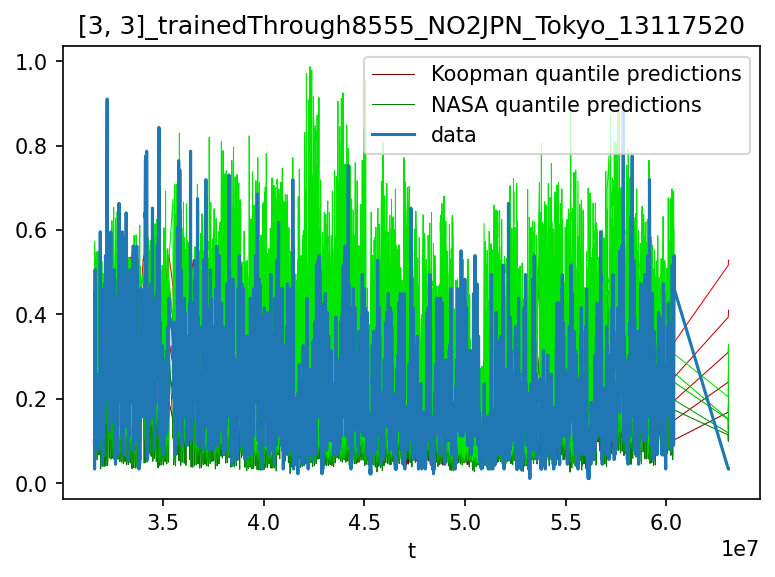

In [297]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [298]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [299]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

In [300]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

In [301]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

<IPython.core.display.Javascript object>


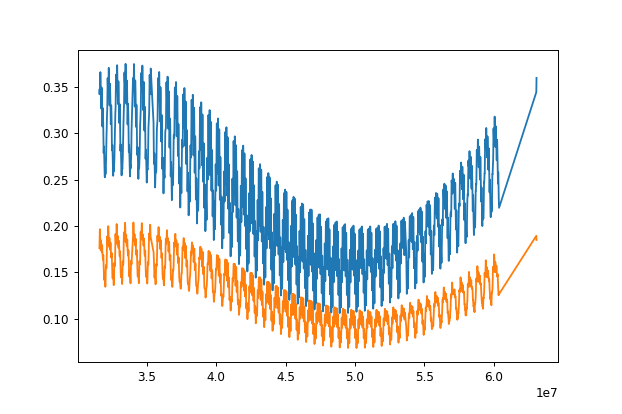

In [302]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

In [303]:
del x, xt, t, tt

# CHEMICAL O3
## GET CHEMICAL

In [304]:
chemical = "O3"
x = np.expand_dims(obs_o3.conc_obs.values, -1)
t = obs_o3.t.values
print("x", x.shape)
print("t", t.shape)

x (0, 1)
t (0,)


In [199]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [200]:
if x.min() <= 0:
    print("negative observed concentration: ", x[x<=0])
    x[x <= 0] = 1e-20

negative observed concentration:  [-0.05  0.    0.   -0.25 -0.05 -0.05  0.   -0.05  0.   -0.05  0.   -0.15
 -0.65  0.    0.   -0.2   0.   -0.3  -0.4  -0.05 -0.05 -0.1  -0.2  -0.4
 -0.1  -0.3  -0.3  -0.25 -0.1   0.    0.    0.   -0.1  -0.55 -0.2  -0.1
 -0.15  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.25
 -0.5  -0.05  0.    0.   -0.05  0.    0.    0.    0.    0.   -0.05  0.
 -0.05  0.    0.    0.   -0.1   0.    0.    0.    0.   -0.15  0.    0.
  0.    0.    0.   -0.15 -0.25 -0.4  -0.05 -0.05 -0.05  0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   -0.05  0.    0.   -0.3
 -0.1  -0.15  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.  

In [201]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (24758, 1)
t (24758,)


In [202]:
plt.figure()
plt.plot(t, x)

<IPython.core.display.Javascript object>

In [203]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [204]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (24758, 1)
xt (8209, 1)


In [205]:
mod_quant_preds = 1e9 / rnge * (mods_o3[1:, :] + mods_o3[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [206]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [207]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [208]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.11918261
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.13255888
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.14516748
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.15699148
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   60480

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.38363642
Iteration  36
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.38949868
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.39437875
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.39984506
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5264398
Iteration  72
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52904713
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5319786
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5341828
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400., 

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5891478
Iteration  108
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.59084797
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5914301
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.59256065
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6189311
Iteration  144
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6194906
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6201045
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6212285
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6375217
Iteration  180
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6378337
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.63804996
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.63881564
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6501932
Iteration  216
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6497876
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6504059
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6509796
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

In [209]:
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [210]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [211]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

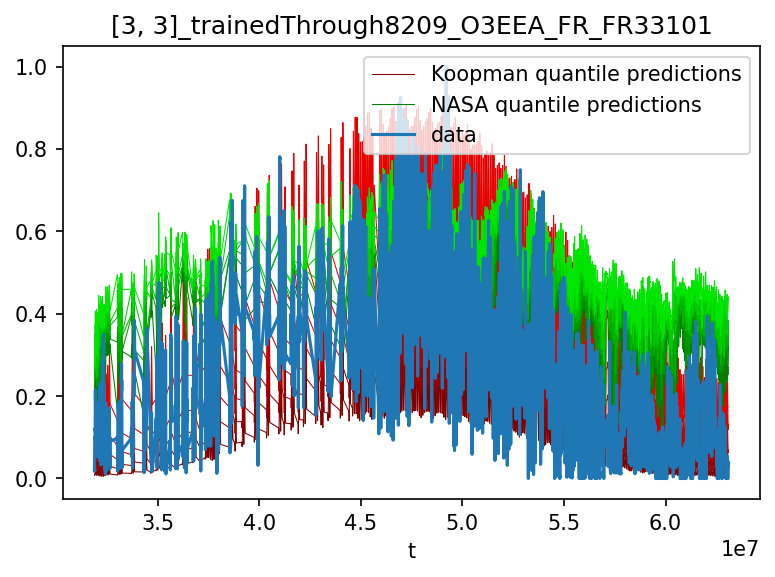

In [212]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [305]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [222]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

NameError: name 'x' is not defined

In [216]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

In [306]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

<IPython.core.display.Javascript object>


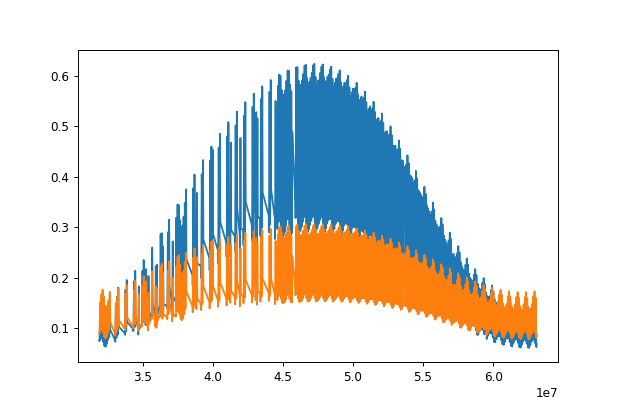

In [218]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

In [307]:
del x, xt, t, tt

NameError: name 'xt' is not defined

# CHEMICAL PM25
## GET CHEMICAL

In [308]:
chemical = "PM25"
x = np.expand_dims(obs_pm25.conc_obs.values, -1)
t = obs_pm25.t.values
print("x", x.shape)
print("t", t.shape)

x (21443, 1)
t (21443,)


In [309]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [310]:
if x.min() <= 0:
    print("negative observed concentration: ", x[x <= 0])
    x[x <= 0] = 1e-20

negative observed concentration:  [ 0.  0.  0. -1. -1. -3. -3. -1.  0.  0. -1. -1.  0. -1. -1.  0. -4.  0.
 -1. -1. -4. -1.  0.  0.  0. -3. -4. -1. -1. -1. -1.  0. -1.  0. -1. -1.
 -2.  0.  0.  0. -1.  0. -3. -2. -1. -1. -1. -2. -4.  0.  0. -3. -2.  0.
  0. -2.  0. -1.  0.  0.  0. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
 -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0. -2.
 -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3. -1. -2.
 -1.  0. -1.  0. -2. -4.  0.  0. -1.  0.  0. -2.  0.  0.  0. -1. -2. -1.
 -1.  0. -1. -1.  0.  0.  0.  0. -2.  0. -2.  0. -3.  0.  0. -2.  0.  0.
 -1. -1.  0.  0. -1. -1. -1. -1.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


In [311]:
x_original = x
rnge = np.std(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (21443, 1)
t (21443,)


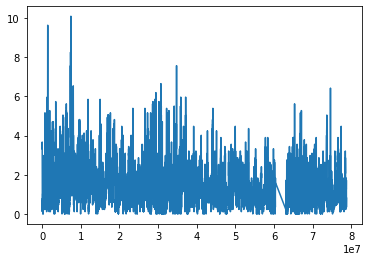

In [312]:
%matplotlib inline
plt.figure()
plt.plot(t, x)

In [313]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [314]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (21443, 1)
xt (8662, 1)


In [315]:
mod_quant_preds = 1 / rnge * (mods_pm25[1:, :] + mods_pm25[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [316]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [317]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [318]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  2.2996554
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  2.089779
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.9367766
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.8252375
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4596692
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.459167
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4585284
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4583112
Iteration  40
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   6048

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4459299
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.445609
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4445114
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4444767
Iteration  76
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   6048

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.435234
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4349859
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.43502
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4349961
Iteration  112
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   60

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4282457
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4283354
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4276356
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4280239
Iteration  148
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,  

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4239315
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4239376
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4235764
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4235489
Iteration  184
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,  

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.421359
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4206299
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4215406
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.4217143
Iteration  220
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   

In [319]:
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [320]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [321]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

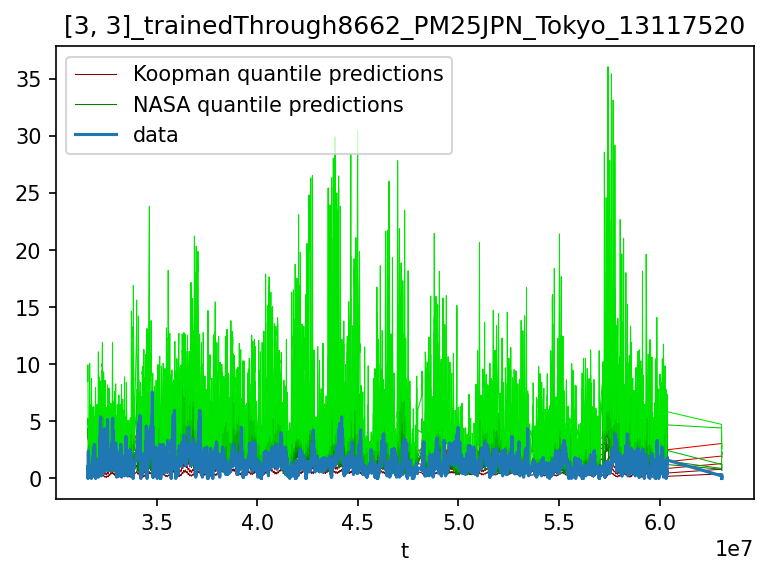

In [322]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [323]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [324]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

In [325]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

In [326]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

<IPython.core.display.Javascript object>


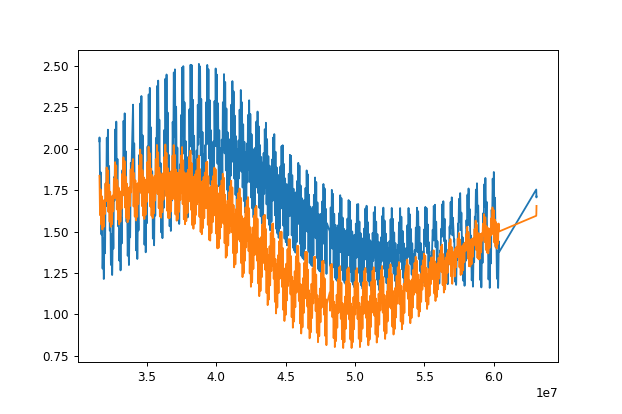

In [327]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

In [328]:
with open(".\\atmo_chem\\NASAcomparison.json", "w") as f:
    f.write(json.dumps(NASAcomparison))
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

In [231]:
with open(".\\atmo_chem\\NASAcomparison.json", "w") as f:
    f.write(json.dumps(NASAcomparison))
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}